In [162]:
import pickle
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from spacy.lang.en import English
from tensorflow.keras.models import Sequential

nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Dage
[nltk_data]     Zhu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [163]:
parent_df = pd.read_csv("parent_reply.csv", sep=',')
talking_head_df = pd.read_csv("talking_head.csv", sep=',')

In [164]:
parent_df.head()

,parent_id,parent,reply,character
0,0,"Oh, I told you. I couldn’t close it. So…",So you’ve come to the master for guidance? Is ...,Michael
1,1,"Actually, you called me in here, but yeah.","All right. Well, let me show you how it’s done.",Michael
2,2,Well. I don’t know.,"If you think she’s cute now, you should have s...",Michael
3,3,What?,Any messages?,Michael
4,4,"Uh, yeah. Just a fax.","Oh! Pam, this is from Corporate. How many time...",Michael


In [165]:
talking_head_df.head()

,quote_id,quote,character
0,0,"Yes, I’d like to speak to your office manager,...",Michael
1,1,"People say I am the best boss. They go, “God w...",Michael
2,2,Corporate really doesn’t really interfere with...,Michael
3,3,"Am I going to tell them? No, I am not going to...",Michael
4,4,I think I’m a role model here. I think I garne...,Michael


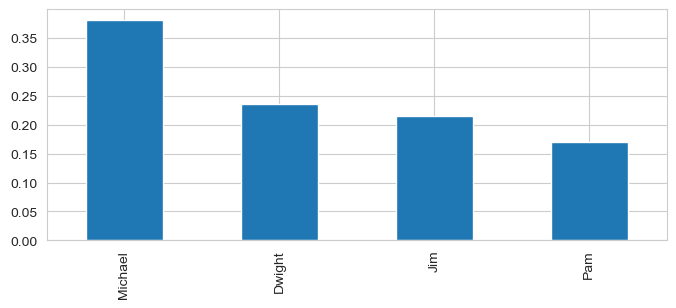

In [166]:
df1 = talking_head_df[['quote', 'character']]
df2 = parent_df[['reply', 'character']]
df2.columns = ['quote', 'character']
df = pd.concat([df1, df2], ignore_index=True)
plt.figure(figsize=(8, 3))
df['character'].value_counts(normalize=True).plot(kind='bar')
plt.show()

In [167]:
df.head()

,quote,character
0,"Yes, I’d like to speak to your office manager,...",Michael
1,"People say I am the best boss. They go, “God w...",Michael
2,Corporate really doesn’t really interfere with...,Michael
3,"Am I going to tell them? No, I am not going to...",Michael
4,I think I’m a role model here. I think I garne...,Michael


In [168]:
porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nlp = English()

In [169]:
# to lower case
df.quote = df.quote.apply(lambda s: s.lower() if type(s) == str else s)
# remove digits
df.replace('\d+', '', regex=True, inplace=True)
# remove punctuation marks
df.quote = df.quote.apply(lambda s: re.sub(r'[^\w\s]', '', s))
# remove superfluous blanks
df.quote = df.quote.apply(lambda s: re.sub(' +', ' ', s))
# tokenization
df.quote = df.quote.apply(lambda column: word_tokenize(column))
# remove stopwords
df.quote = df.quote.apply(lambda x: ' '.join([token for token in x if not nlp.vocab[token].is_stop]))
# normalizing words
df.quote = df.quote.apply(lambda x: ' '.join([porter_stemmer.stem(token) for token in x.split()]))
# lemmatization
df.quote = df.quote.apply(lambda x: ' '.join([lemmatizer.lemmatize(token) for token in x.split()]))
df

,quote,character
0,ye id like speak offic manag ye hello michael ...,Michael
1,peopl best bos god weve work place like your h...,Michael
2,corpor doesnt interfer jan levinson gould jan ...,Michael
3,go tell go tell dont point doctor tell patient...,Michael
4,think im role model think garner peopl respect...,Michael
...,...,...
27894,gift,Pam
27895,ahead,Pam
27896,yeah,Pam
27897,what,Pam


In [170]:
X = df.quote
y = df.character

X = X.to_numpy().reshape(-1, 1)

In [171]:
ROS = RandomOverSampler(sampling_strategy='all', random_state=42)
X, y = ROS.fit_resample(X, y)

In [172]:
X = pd.Series(X.reshape(-1,))
y.value_counts()

Michael    10602
Dwight     10602
Jim        10602
Pam        10602
Name: character, dtype: int64

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [174]:
# Create dictionary and transform to feature vectors.
count_vector = CountVectorizer(stop_words='english', max_features=10000)
X_train_counts = count_vector.fit_transform(X_train).toarray()

In [175]:
# Create test documents and vectorize.
X_test_counts = count_vector.transform(X_test).toarray()

# Multinomial Naive Bayes

In [176]:
# Create model(naive bayes) and training.
clf = MultinomialNB()

0.45787781350482315


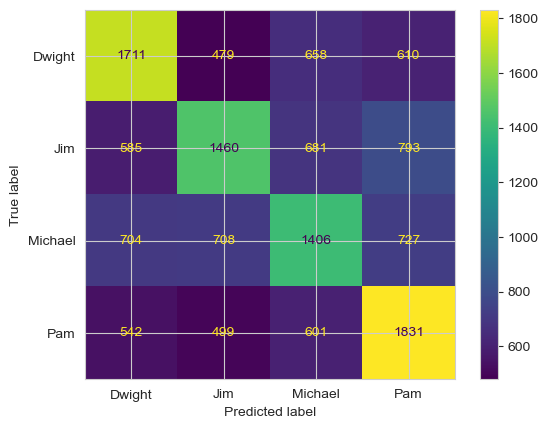

In [177]:
clf.fit(X_train_counts, y_train)
print(clf.score(X_test_counts, y_test))
ConfusionMatrixDisplay.from_estimator(clf, X_test_counts, y_test)

# Gaussian Naive Bayes

0.38913897820650234


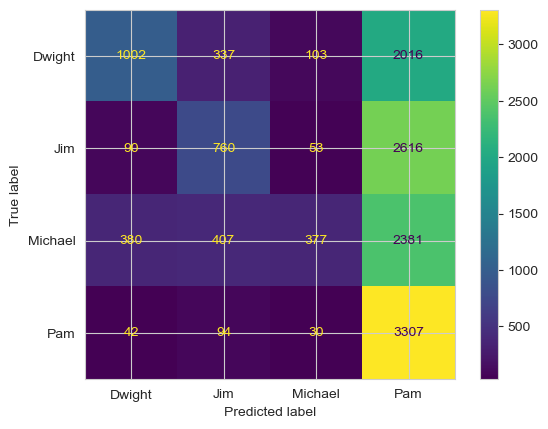

In [178]:
# Create model(naive bayes) and training.
clf = GaussianNB()
clf.fit(X_train_counts, y_train)
print(clf.score(X_test_counts, y_test))
ConfusionMatrixDisplay.from_estimator(clf, X_test_counts, y_test)

# KNN

0.422508038585209


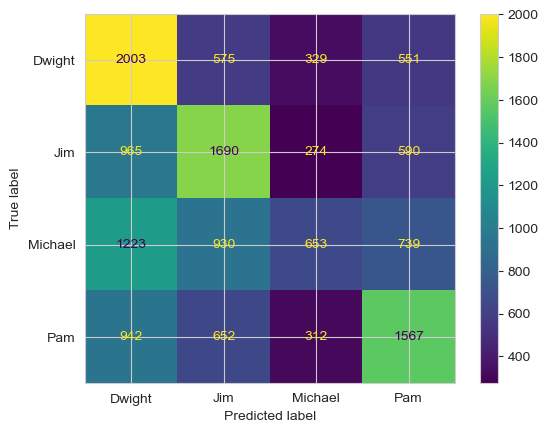

In [179]:
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(X_train_counts, y_train)
print(clf.score(X_test_counts, y_test))
ConfusionMatrixDisplay.from_estimator(clf, X_test_counts, y_test)

# ANN

In [180]:
model = Sequential()
model.add(Dense(512, input_shape=(8711,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [181]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [182]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_train = np_utils.to_categorical(y_train, 4)
y_test = encoder.transform(y_test)
y_test = np_utils.to_categorical(y_test, 4)
history = model.fit(X_train_counts, y_train, epochs=250, batch_size=32, verbose=2, callbacks=[callback],
                    validation_split=0.2)

Epoch 1/250
711/711 - 13s - loss: 1.2834 - accuracy: 0.3942 - val_loss: 1.2070 - val_accuracy: 0.4535 - 13s/epoch - 18ms/step
Epoch 2/250
711/711 - 13s - loss: 1.0581 - accuracy: 0.5384 - val_loss: 1.1767 - val_accuracy: 0.4755 - 13s/epoch - 18ms/step
Epoch 3/250
711/711 - 12s - loss: 0.8953 - accuracy: 0.6138 - val_loss: 1.1784 - val_accuracy: 0.4964 - 12s/epoch - 17ms/step
Epoch 4/250
711/711 - 12s - loss: 0.7829 - accuracy: 0.6615 - val_loss: 1.2011 - val_accuracy: 0.5154 - 12s/epoch - 17ms/step
Epoch 5/250
711/711 - 12s - loss: 0.6998 - accuracy: 0.6994 - val_loss: 1.2345 - val_accuracy: 0.5193 - 12s/epoch - 16ms/step
Epoch 6/250
711/711 - 13s - loss: 0.6474 - accuracy: 0.7197 - val_loss: 1.2705 - val_accuracy: 0.5261 - 13s/epoch - 18ms/step
Epoch 7/250
711/711 - 12s - loss: 0.6029 - accuracy: 0.7382 - val_loss: 1.3069 - val_accuracy: 0.5360 - 12s/epoch - 17ms/step
Epoch 8/250
711/711 - 12s - loss: 0.5744 - accuracy: 0.7469 - val_loss: 1.3481 - val_accuracy: 0.5406 - 12s/epoch - 16

438/438 [==============================] - 2s 5ms/step


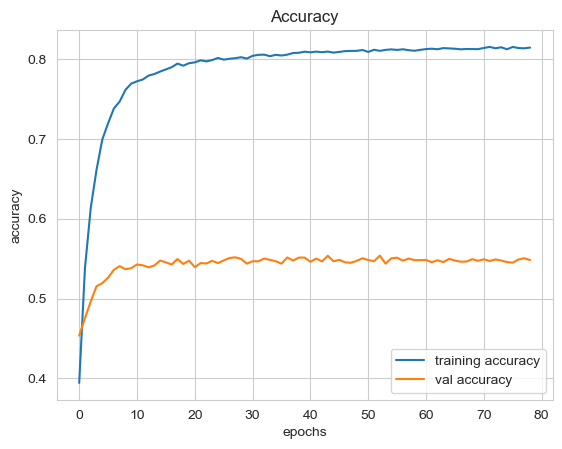

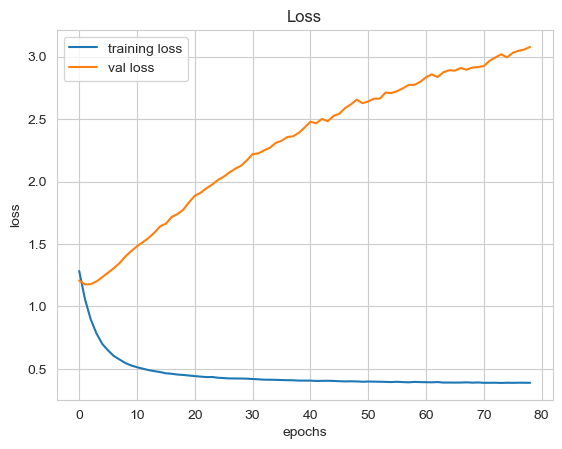

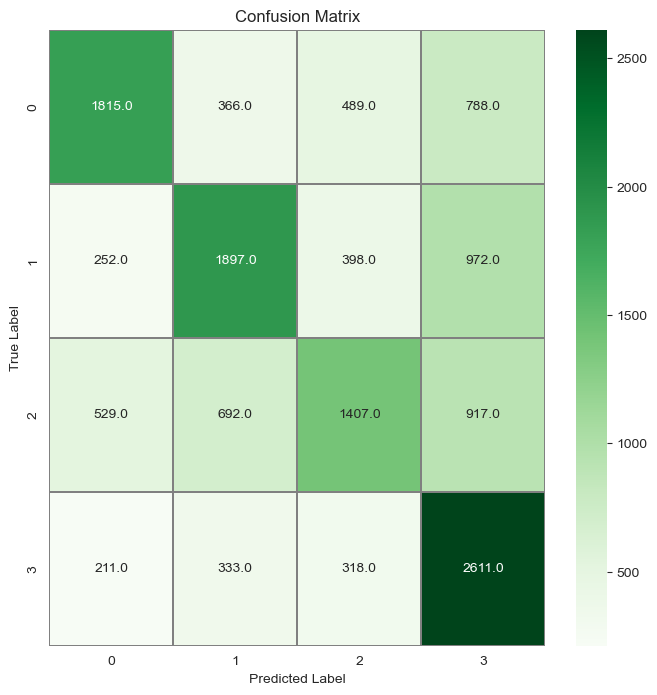

In [183]:
plt.figure(0)

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# confusion matrix
# Predict the values from the test dataset
Y_pred = model.predict(X_test_counts)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert test observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
# test